### Creating and  Evaluating Water Quality Prediction Model

##### Introduction
The Water Potability Prediction Model is a data-driven solution designed to evaluate and predict the potability of water from various sources based on crucial water quality metrics. With access to water quality data for 3,276 water bodies, this model plays a significant role in addressing concerns related to the safety and suitability of drinking water.

For a data science team charged with creating this model, they will usually undergo a set of key tasks: 

1. Installation and Imports: Start by setting up the necessary libraries and modules.
2. Data Loading: Retrieve the water quality dataset from the Lakehouse for analysis.
3. Exploratory Data Analysis (EDA): Dive into the data to understand its key statistics, and identify any patterns.
4. Data Visualization: Create visual representations of the data to gain insights and identify trends.
5. Outlier Detection and Removal: Identify and remove any outliers or anomalies in the dataset.
6. Handling Imbalanced Data: Address any class imbalances in the data to ensure fair modeling.
7. Data Splitting: Divide the dataset into training and testing sets.
8. Model Training and Evaluation: Train the selected models and evaluate their performance.
9. Store prediction into OneLake back

##### Step 1: Installation and Imports

Libraries are essential components that provide pre-written code, functions, and classes, which save developers time and effort by allowing to leverage existing solutions for various tasks in  programs. These libraries cover a wide range of functionalities, making it easier for developers to build robust and feature-rich applications without reinventing the wheel.

In [1]:
pip install -U imbalanced-learn

StatementMeta(, 02023b4a-a183-45a0-aa08-078c608ae885, 5, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, f1_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

print("All Modules Loaded")

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 6, Finished, Available)

All Modules Loaded


##### Step 2: Creating required Functions

In [3]:
# This function creates distribution subplots.
def show_distributions(columns: list, data: pd.DataFrame, nrows: int = 1, ncols: int = 3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        sns.histplot(data[column], kde=True, ax=axes[index])
        axes[index].set_title(column)
    plt.tight_layout()
    plt.show()

# This function creates box plot subplots.
def show_boxplots(columns: list, data: pd.DataFrame, nrows: int = 3, ncols: int = 3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        axes[index].boxplot(data[column])
        axes[index].set_title(column)
    plt.tight_layout()
    plt.show()

# This function Conducts Shapiro-Wilk test.
def normality_test(columns: list, data: pd.DataFrame):
    for i in columns:
        results = shapiro(data[data[i].isna() == False][i])
        print(i, results.statistic)

# Performs random sample imputation for missing values
def random_sample_imputation(df):
    cols_with_missing_values = df.columns[df.isna().any()].tolist()
    for var in cols_with_missing_values:
        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(), random_state=0)
        random_sample_df.index = df[df[var].isnull()].index
        df.loc[df[var].isnull(), var] = random_sample_df
    return df

#This function will give Visualizes Isolation Forest results with different contamination values
def visualize_isolation_forest(columns: list, data: pd.DataFrame, contamination: list,nrows: int = 2, ncols: int = 3,):
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, i in enumerate(contamination):
        model = IsolationForest(contamination=i)  # Adjust the contamination parameter
        model.fit(data.to_numpy())
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == -1], x = columns[0], y = columns[1], color='blue', label='Outlier', ax = axes[index])
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == 1], x = columns[0], y = columns[1], color='red', label='Normal', ax = axes[index])
        axes[index].legend()
        axes[index].set_title(f"Contamination Value: {round(i,3)}")
    plt.show()

#This function Applies Isolation Forest to remove outliers from the data
def remove_outliers(data: pd.DataFrame, contamination: int):
    model = IsolationForest(contamination = contamination)
    model.fit(data.to_numpy())
    return data[model.predict(data.to_numpy()) == 1]

#This function Creates ROC plots for multiple models.
def roc_plot(models: list, X_test: pd.DataFrame, y_test: pd.DataFrame):
    plt.figure(figsize=(20,10))
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    for model in models:
        lr_probs = model.predict_proba(X_test)
        lr_probs = lr_probs[:, 1]
        lr_auc = roc_auc_score(y_test, lr_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        plt.plot(lr_fpr, lr_tpr, marker='.', label = model["classifier"])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

#This function Visualizes model feature importance.
def forest_feature_importance(model,X_test):
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

#This function Visualizes model feature importance using permutation. 
def forest_permutation_importance(model, X_test, y_test, n_repeats:int = 10):
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    result = permutation_importance(
        model, X_test.to_numpy(), y_test, n_repeats=n_repeats, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(importances, index = feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 7, Finished, Available)

##### Step 3: Load water quality dataset from Lakehouse

In [26]:
# df = spark.read.format("csv").option("header","true").load("Files/Water-Data/Water-quality-data.csv")
# data = df.toPandas()
# data.head()

data = pd.read_csv("/lakehouse/default/Files/Water-Data/Water-quality-data.csv")

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 76, Finished, Available)

##### Step 4: Exploratory Data Analysis (EDA)

###### Step 4.1: Descriptive Statistics
We can see that there are a lot of missing values in "ph", "Sulfate" and "Trihalomethanes".

In [21]:
data.describe()

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 58, Finished, Available)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,OrganicCarbon,Trihalomethanes,Turbidity,WaterQuality
count,2785,3276,3276,3276,2495,3276,3276,3114,3276,3276
unique,699,2835,3276,722,2303,3099,1235,2403,403,2
top,6.28,211.45,20791.32,7.30,334.05,399.95,13.45,56.35,3.76,0
freq,15,5,1,16,4,3,10,4,23,1998


###### Step 4.2: Checking for missing data.

In [16]:
data.isna().sum()

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 20, Finished, Available)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
OrganicCarbon        0
Trihalomethanes    162
Turbidity            0
WaterQuality         0
dtype: int64

###### Step 4.3: Correlation plot
Before dealing with missing data first check for the correlation. From the heat map we can see that there very low correlation between the predictors.

In [27]:
data.info()


StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 77, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   OrganicCarbon    3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   WaterQuality     3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 78, Finished, Available)

<AxesSubplot: >

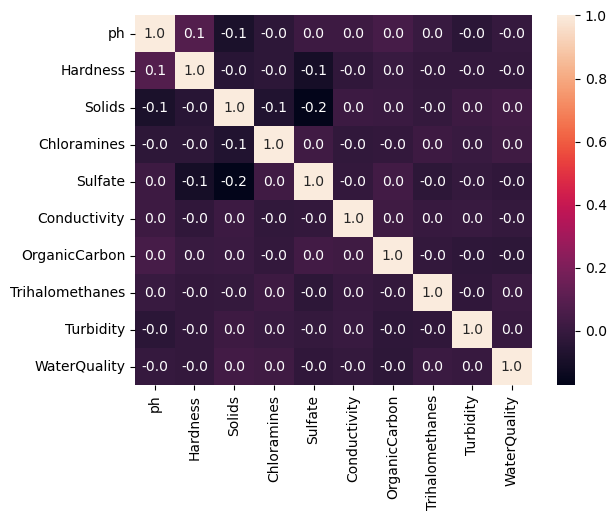

In [28]:
sns.heatmap(data.corr(), annot = True,fmt='.1f') 

##### Step 5: Data Visualization 
 We can see that most of the data is close to normal distribution.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 80, Finished, Available)

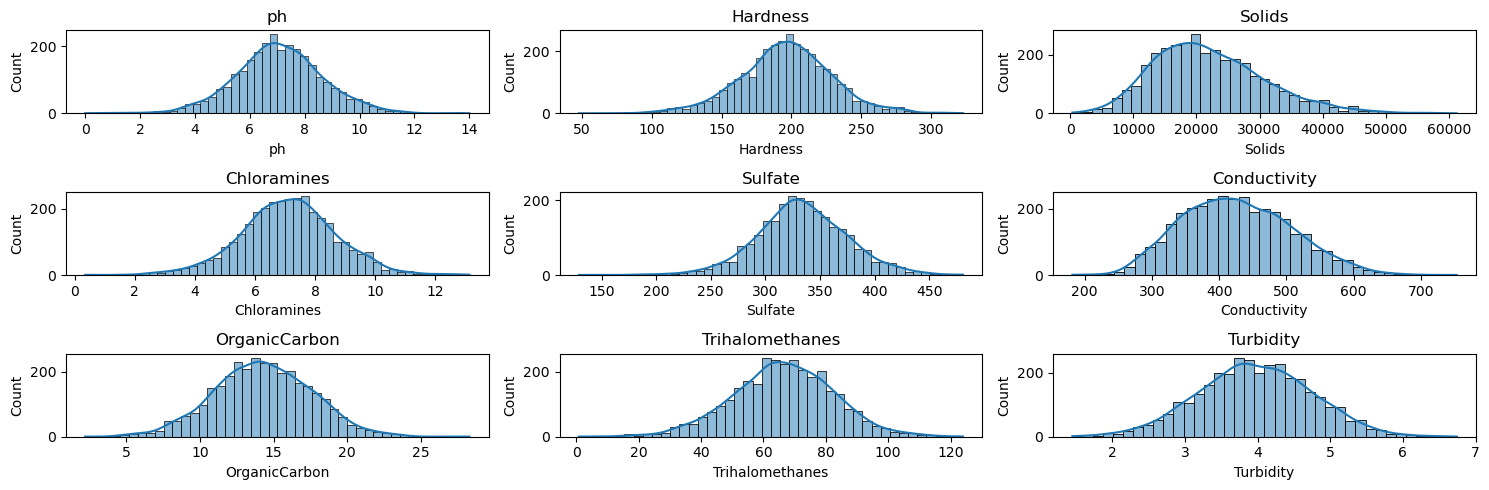

In [30]:
show_distributions(data.columns[:-1], data,3,3)

###### Step 5.1: Dealing with missing data
It is an essential part of data pre-processing in data analysis and machine learning. Missing data can lead to biased or inaccurate results, so it's crucial to handle them appropriately.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 81, Finished, Available)

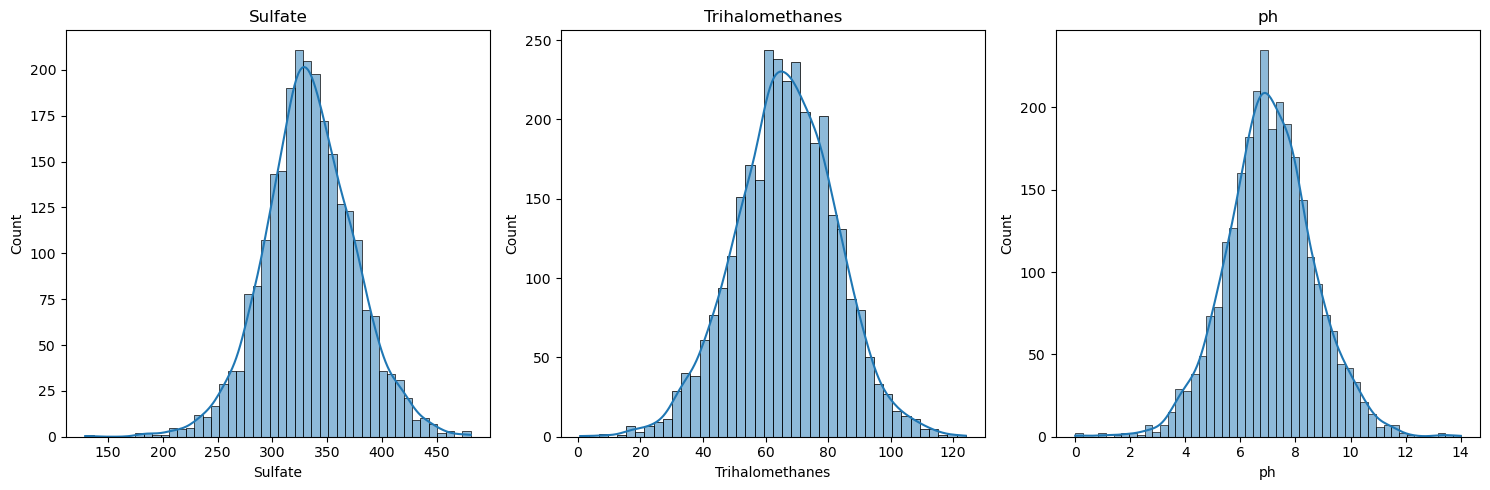

In [31]:
missing_columns = ["Sulfate", "Trihalomethanes", "ph"]
show_distributions(missing_columns, data)

Fills missing values in columns "Sulfate," "Trihalomethanes," and "ph" with their respective column means.


In [32]:
for i in ["Sulfate", "Trihalomethanes", "ph"]:
    data_mean = data.fillna(data.mean())

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 82, Finished, Available)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 83, Finished, Available)

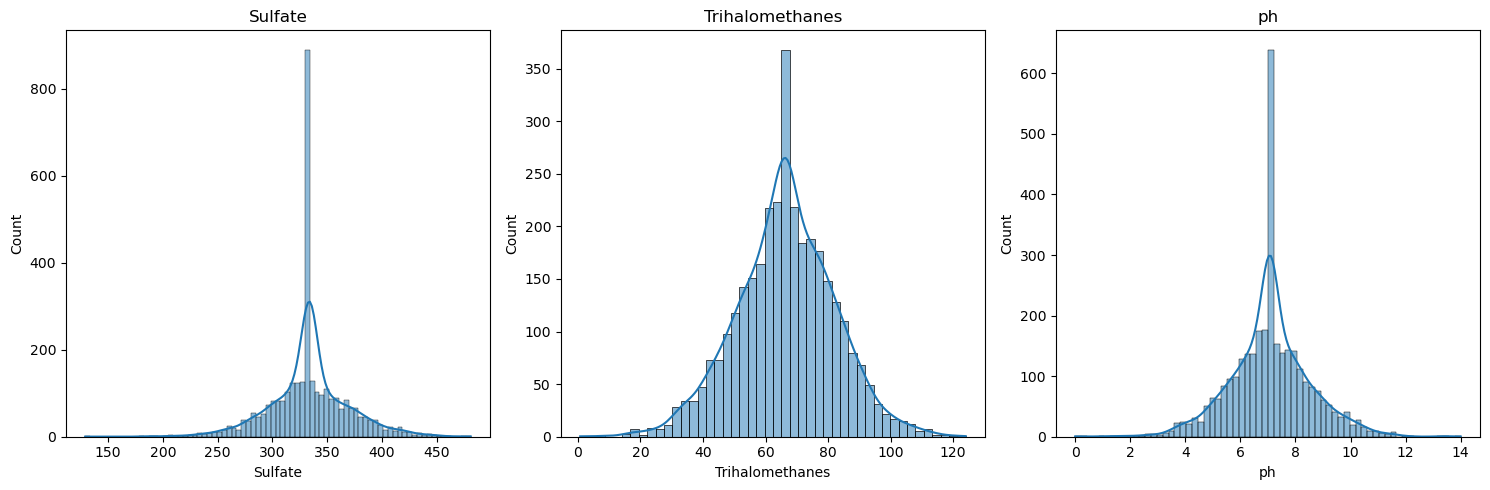

In [33]:
show_distributions(missing_columns, data_mean)

###### Step 5.2: Performs random sample imputation for missing values

In [34]:
data_random = random_sample_imputation(data)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 84, Finished, Available)

We can see that if handle missing values at random data is much nicely distributed.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 85, Finished, Available)

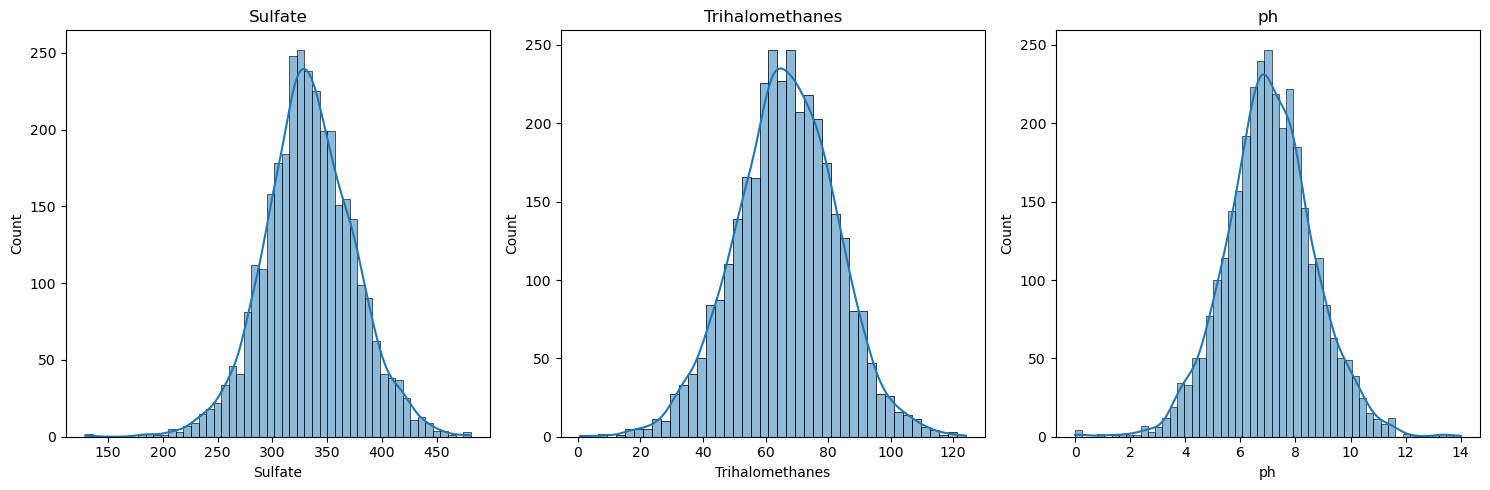

In [35]:

show_distributions(missing_columns, data_random)

###### Step 5.3: Outlier Detection and Removal
Dealing with outliers is essential because outliers can significantly impact statistical analysis and machine learning models, potentially leading to biased or inaccurate results. It's essential to consider how to address them appropriately.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 86, Finished, Available)

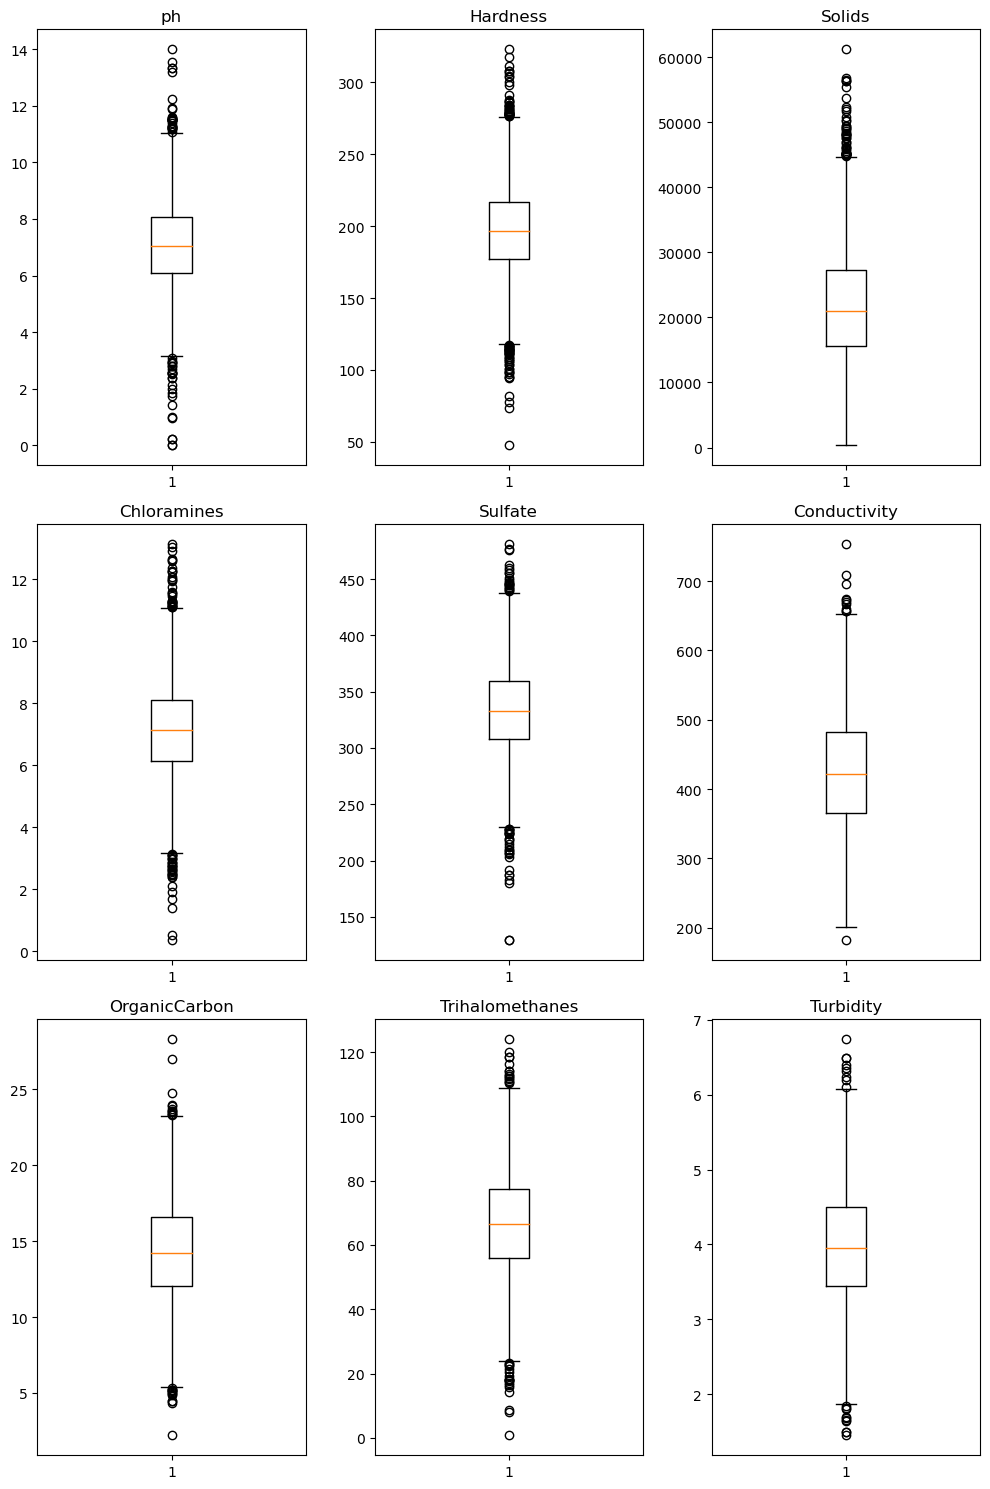

In [36]:
# From boxplots we can see that there a lots of outliers in the data.
show_boxplots(data_random.columns[:-1], data_random)

###### Step 5.4: Visualizing effect of Isolation Forest with different contamination values

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 87, Finished, Available)

2023-10-18:11:38:38,732 ERROR    [synapse_mlflow_utils.py:420] [fabric mlflow plugin]: <class 'synapse.ml.mlflow.tracking_store.TridentMLflowTrackingStore'>.create_experiment exception  create experiment get return code: 400, body: b'{"error":{"code":"BadRequest","pbi.error":{"code":"BadRequest","exceptionCulprit":1}}}', headers: {'Cache-Control': 'no-store, must-revalidate, no-cache', 'Pragma': 'no-cache', 'Transfer-Encoding': 'chunked', 'Content-Type': 'application/json; charset=utf-8', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'X-Frame-Options': 'deny', 'X-Content-Type-Options': 'nosniff', 'RequestId': 'e48baacd-2e69-4ff5-92e6-a41d3d381724', 'Access-Control-Expose-Headers': 'RequestId', 'Date': 'Wed, 18 Oct 2023 11:38:38 GMT'}
2023-10-18:11:38:38,751 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/ho

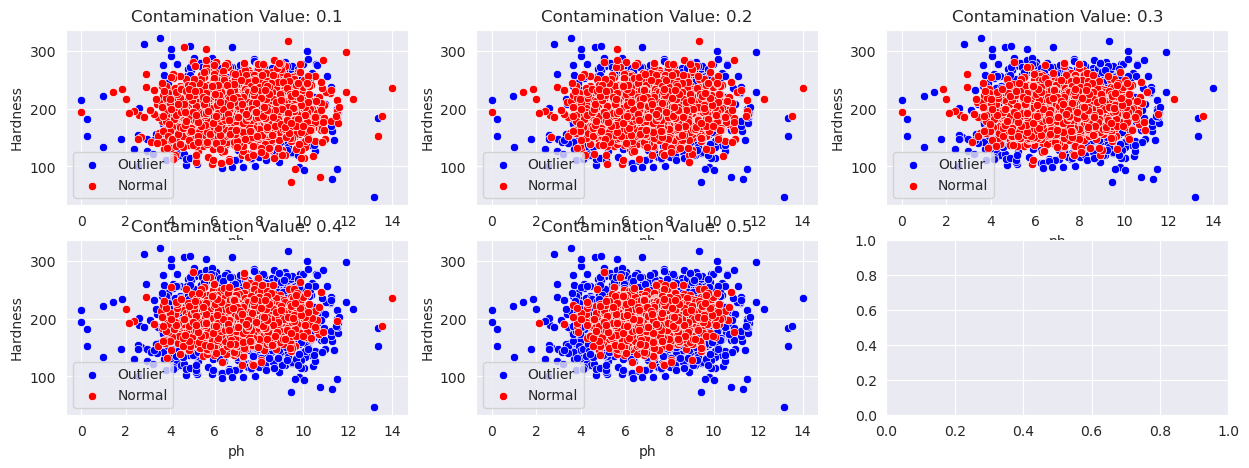

In [37]:
# Using IsolationForest to identify outliers
contamination = np.arange(0.1, 0.6, 0.1)

visualize_isolation_forest(["ph", "Hardness"], data_random,contamination)

###### Step 5.5: Remove outliers using IsolationForest

In [38]:
data_forest = remove_outliers(data_random, 0.3)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 88, Finished, Available)

2023-10-18:11:38:45,337 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/synapse/ml/mlflow/default_experiment_registry.py", line 41, in get_experiment_id
    return mlflow.set_experiment(f"{artifact_name}").experiment_id
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/_tracking_

uses the Isolation Forest algorithm to identify and visualize outliers in the dataset based on the "ph" and "Solids" columns

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 89, Finished, Available)

2023-10-18:11:38:46,663 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/synapse/ml/mlflow/default_experiment_registry.py", line 41, in get_experiment_id
    return mlflow.set_experiment(f"{artifact_name}").experiment_id
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/_tracking_

<AxesSubplot: xlabel='ph', ylabel='Solids'>

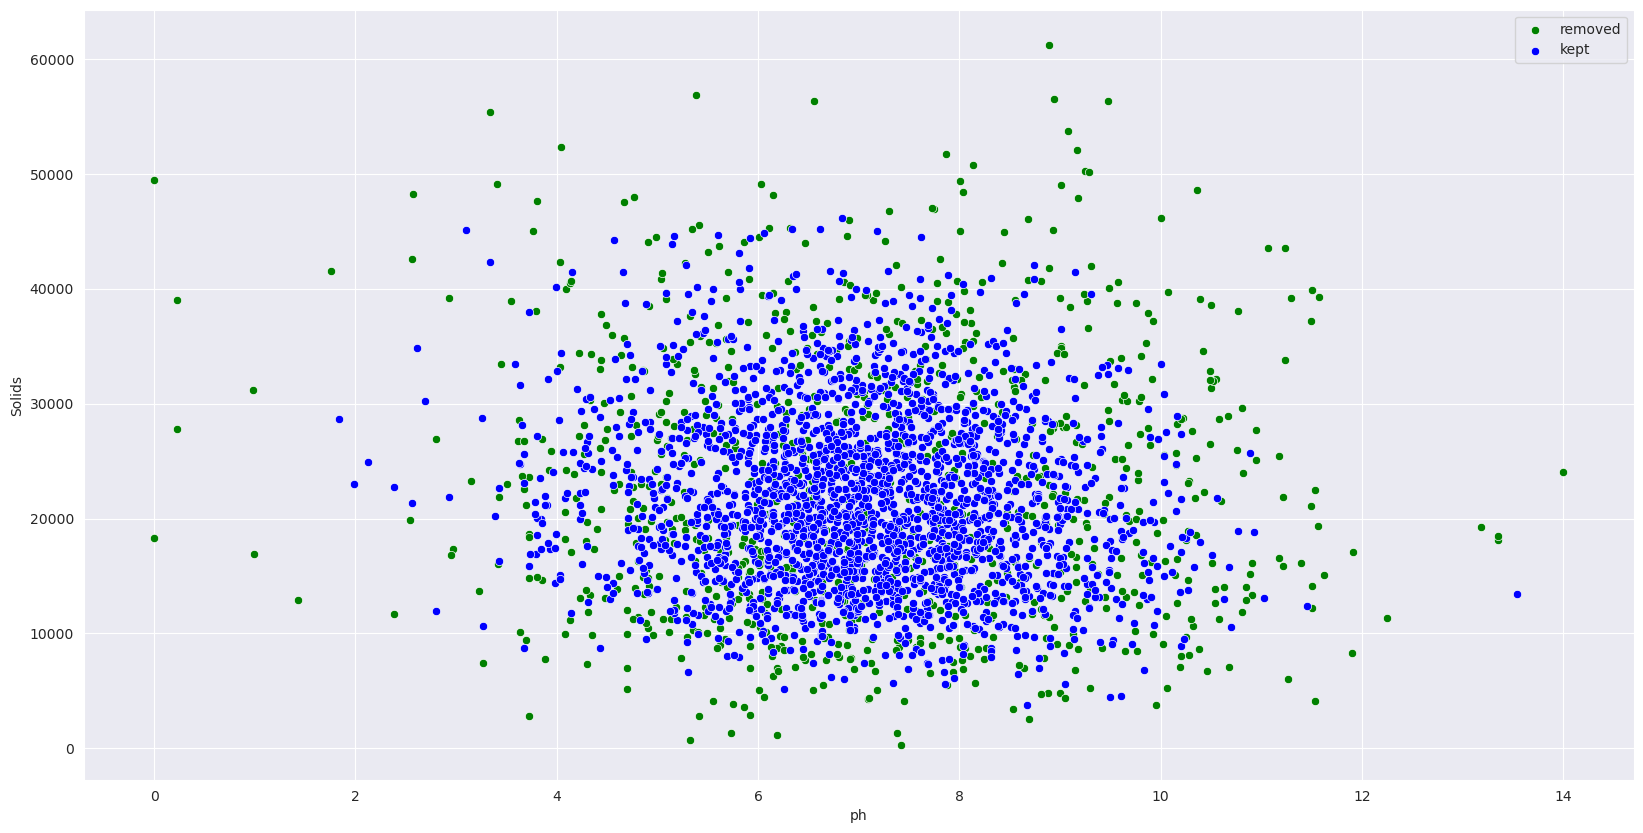

In [39]:
model = IsolationForest(contamination = 0.3)
model.fit(data_random.to_numpy())
data_random[model.predict(data_random.to_numpy()) == -1]
plt.figure(figsize= (20,10))
sns.scatterplot(data = data_random[model.predict(data_random.to_numpy()) == -1], x = "ph", y = "Solids", color = "green", label = "removed")
sns.scatterplot(data = data_random[model.predict(data_random.to_numpy()) == 1], x = "ph", y = "Solids", color = "blue", label = "kept")

Boxplots to visualize the data distribution and We can observe the reduction in outliers compared to a previous boxplot.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 90, Finished, Available)

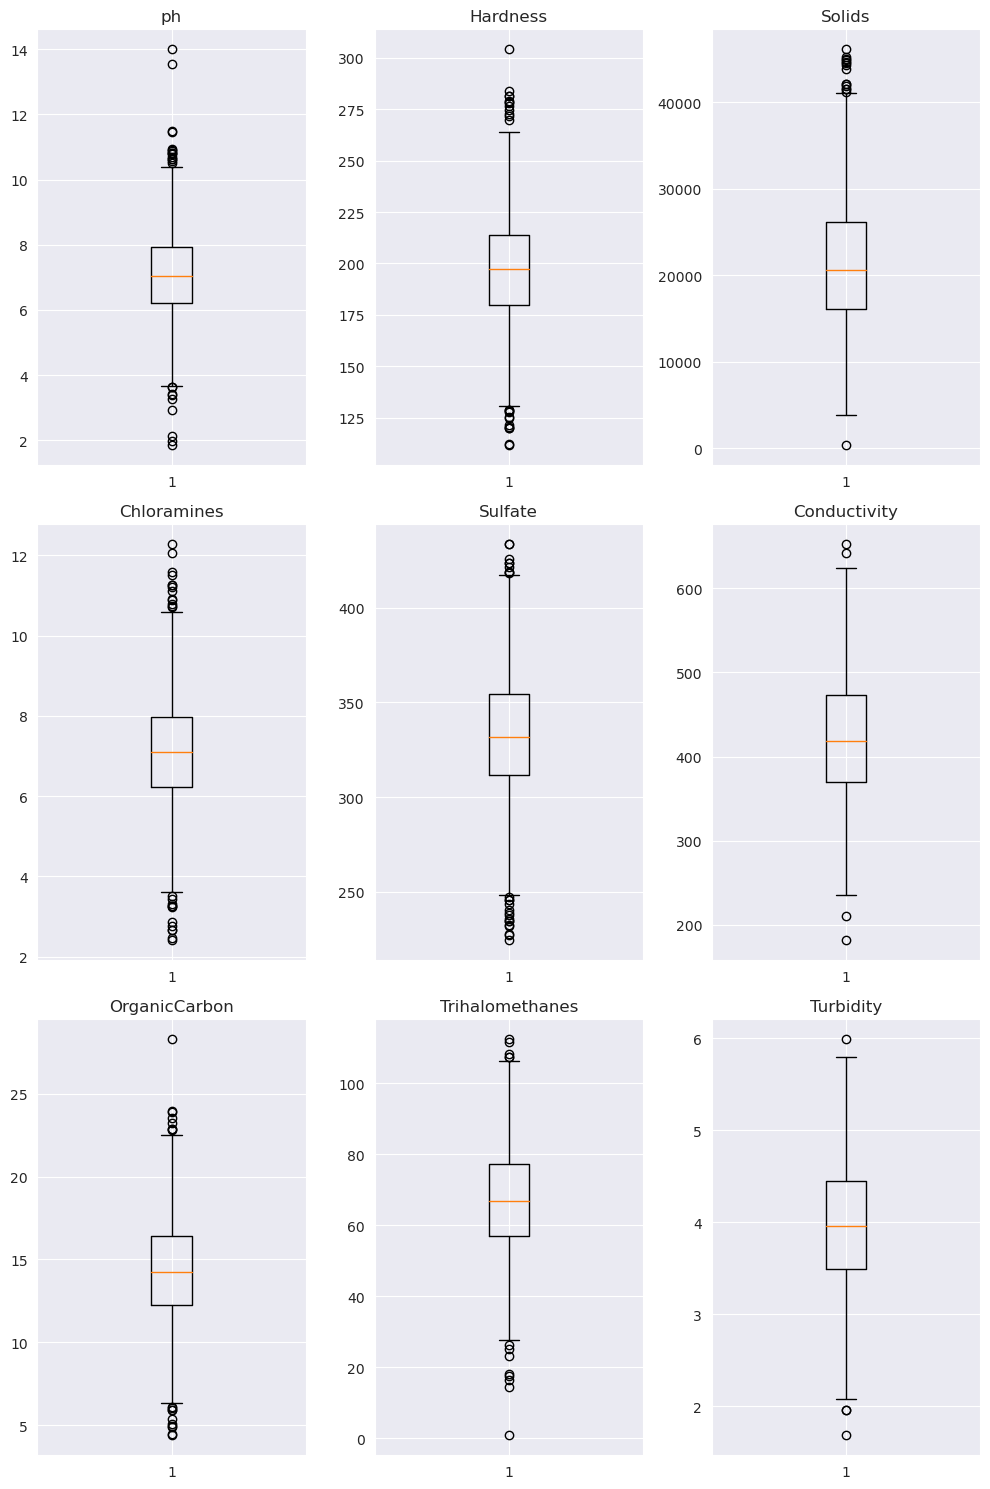

In [40]:
# We can see that there is less outliers.
show_boxplots(data_forest.columns[:-1], data_forest)

##### Step 6: Handling Imbalanced Data

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 91, Finished, Available)

<AxesSubplot: xlabel='WaterQuality', ylabel='count'>

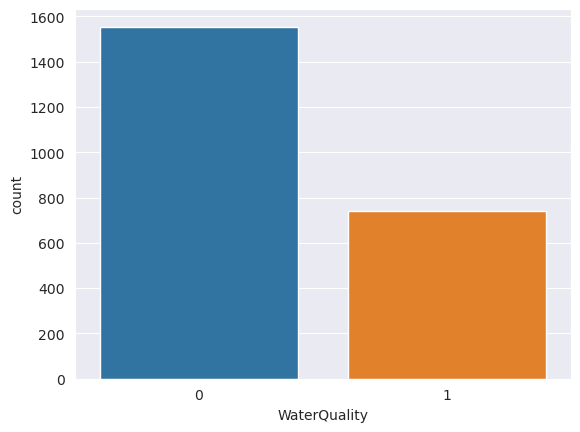

In [41]:
#search for graph
sns.countplot(data=data_forest, x="WaterQuality")

Oversampling using SMOTE (Synthetic Minority Over-sampling Technique) is a common approach to address class imbalance in datasets because we have imbalanced data set we are going to oversample our data using SMOTE.

In [42]:
sm = SMOTE(random_state=42)

X, y = data_forest[data_forest.columns[:-1]], data_forest["WaterQuality"]
X, y = sm.fit_resample(X, y)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 92, Finished, Available)

2023-10-18:11:38:51,644 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/synapse/ml/mlflow/default_experiment_registry.py", line 41, in get_experiment_id
    return mlflow.set_experiment(f"{artifact_name}").experiment_id
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/_tracking_

##### Step 7: Spliting the data into train and test data.
Fitting multiple models with 5-fold cross-validation in machine learning is to assess and compare the performance of different models.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 93, Finished, Available)

##### Step 8: Model Training and Evaluation

In [44]:
models = [RandomForestClassifier(), LogisticRegression(), AdaBoostClassifier(), KNeighborsClassifier(), QuadraticDiscriminantAnalysis(), GaussianNB(), SVC(probability=True), DecisionTreeClassifier(), LGBMClassifier()]

pipelines = {}
for model in models:
    model_name = str(model.__class__).split(".")[-1].split("'")[0]
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # Preprocessing step
        ("classifier", model)  # Classifier step
    ])
    pipelines[model_name] = pipe


for name,pipe in pipelines.items():
    print(f"Training {name}")
    scores = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = "accuracy")
    print(f"Mean Score {scores.mean()} -- Std {scores.std()} -- Min {scores.min()} -- Max {scores.max()}")

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 94, Finished, Available)

Training RandomForestClassifier
Mean Score 0.7232926818060674 -- Std 0.026302167423790736 -- Min 0.6716738197424893 -- Max 0.7424892703862661
Training LogisticRegression
Mean Score 0.5238082546801335 -- Std 0.03155492571174602 -- Min 0.4678111587982833 -- Max 0.555793991416309
Training AdaBoostClassifier
Mean Score 0.6396366176213801 -- Std 0.008041902789477558 -- Min 0.628755364806867 -- Max 0.6466809421841542
Training KNeighborsClassifier
Mean Score 0.6529376625524994 -- Std 0.014725680583778948 -- Min 0.6394849785407726 -- Max 0.6802575107296137
Training QuadraticDiscriminantAnalysis
Mean Score 0.6791041346922646 -- Std 0.02057243110916358 -- Min 0.6416309012875536 -- Max 0.6995708154506438
Training GaussianNB
Mean Score 0.6340581375044803 -- Std 0.02503605529145605 -- Min 0.5944206008583691 -- Max 0.6587982832618026
Training SVC
Mean Score 0.6924097747470385 -- Std 0.015681774019621147 -- Min 0.6738197424892703 -- Max 0.721030042918455
Training DecisionTreeClassifier
Mean Score 0.6

Visualizing the Receiver Operating Characteristic (ROC) plot is a great way to assess the performance of classification models and from the plot results we can see that Random Forest is the best model.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 95, Finished, Available)

2023-10-18:11:39:04,249 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/synapse/ml/mlflow/default_experiment_registry.py", line 41, in get_experiment_id
    return mlflow.set_experiment(f"{artifact_name}").experiment_id
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/_tracking_

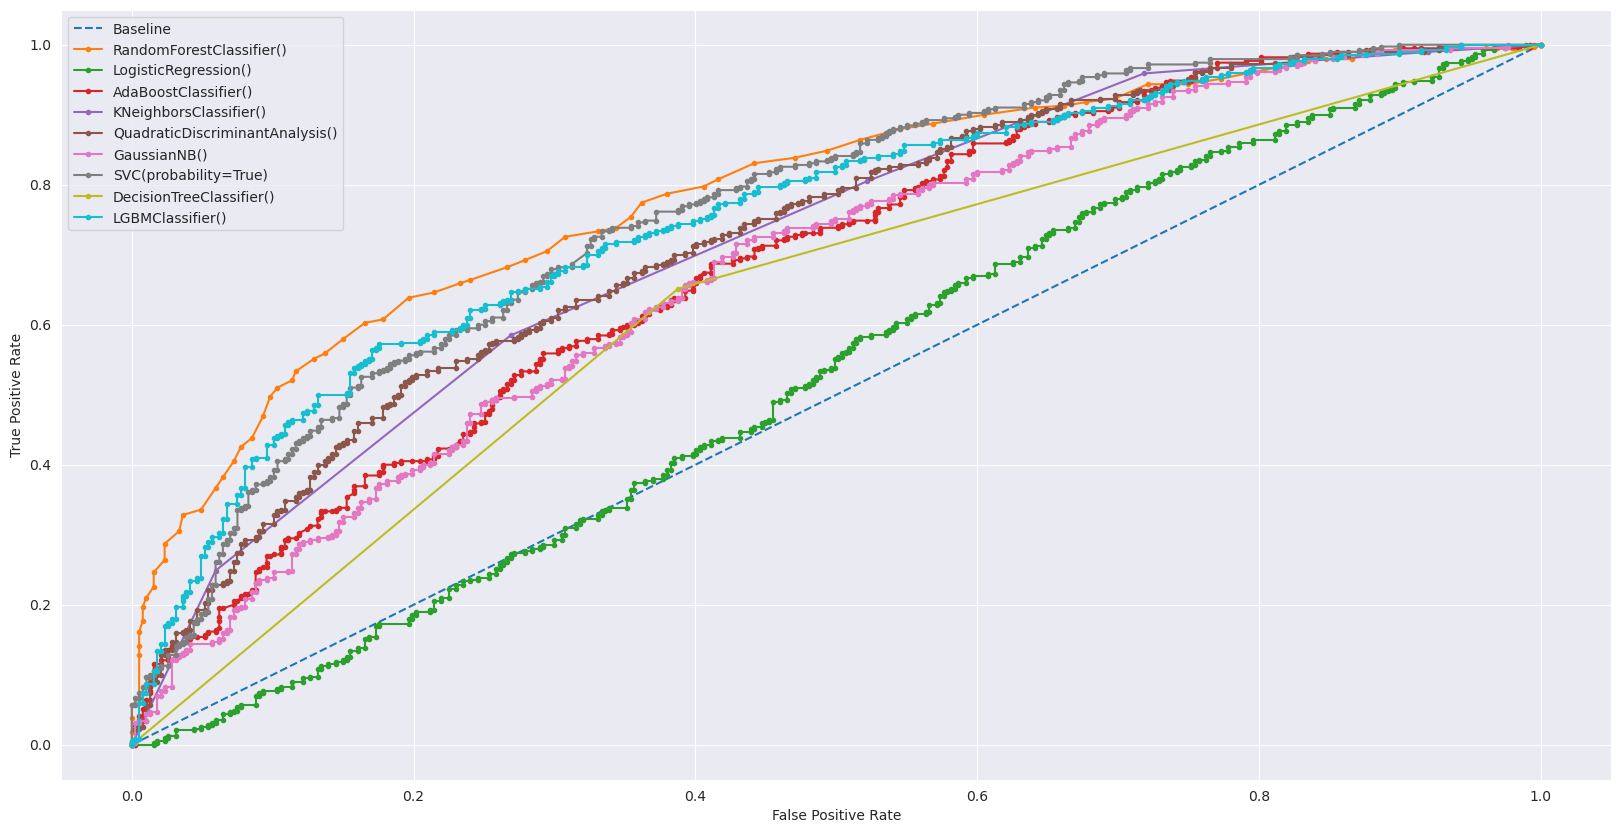

In [45]:
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
roc_plot(list(pipelines.values()), X_test, y_test)

Lets look at the feature importance of the predictors. We can see that almost all the predictors are important for the model's decision.

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 96, Finished, Available)

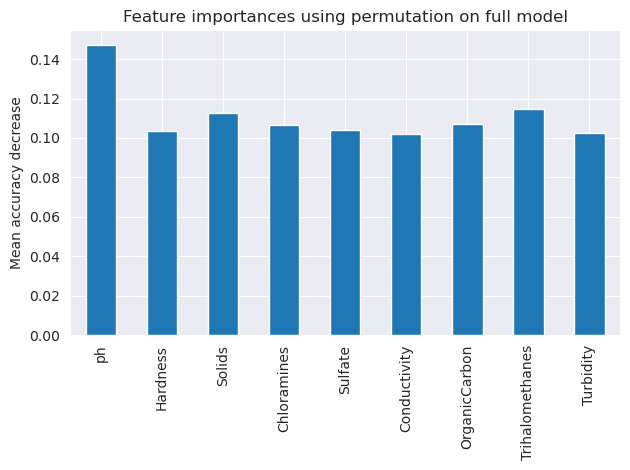

In [46]:
#calculates and visualizes feature importance using permutation importance for the RandomForestClassifier within a pipeline, evaluated on the X_test and y_test datasets.
forest_permutation_importance(pipelines["RandomForestClassifier"]["classifier"],X_test,y_test)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 97, Finished, Available)

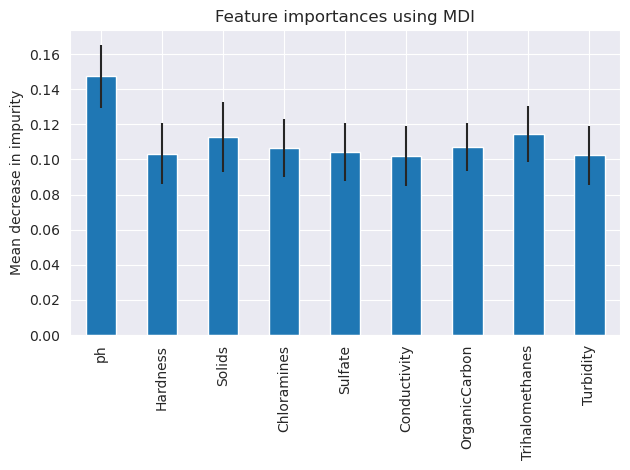

In [47]:
#computes and visualizes feature importance for the RandomForestClassifier within a pipeline using the test data
forest_feature_importance(pipelines["RandomForestClassifier"]["classifier"],X_test)

###### Step 8.1: Hyperparameter tuning the Random Forest model.

In [48]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    'n_estimators': [10, 20, 30, 40,50],
    'max_depth': [5, 10, 20, 30, 50],
}

rf_classifier = RandomForestClassifier(random_state = 42)
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(
    rf_classifier, param_grid, scoring=scorer, cv=5, verbose = 1
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

best_predictions = best_rf.predict(X_test)
best_accuracy = accuracy_score(best_predictions, y_test)

print("Best Accuracy Score:", best_accuracy)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 98, Finished, Available)

2023-10-18:11:39:14,202 ERROR    [default_experiment_registry.py:43] Error find or created notebook/SJD default experiment, please call mlflow.set_experiment to set a valid one before run
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/synapse/ml/mlflow/default_experiment_registry.py", line 41, in get_experiment_id
    return mlflow.set_experiment(f"{artifact_name}").experiment_id
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/tracking/_tracking_

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Accuracy Score: 0.6898326898326899


###### Step 8.2: Random Forest model Evaluation

In [49]:
accuracy_score(best_rf.predict(X_test),y_test)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 99, Finished, Available)

0.6898326898326899

###### Step 8.3: Displays a heatmap of the confusion matrix

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 100, Finished, Available)

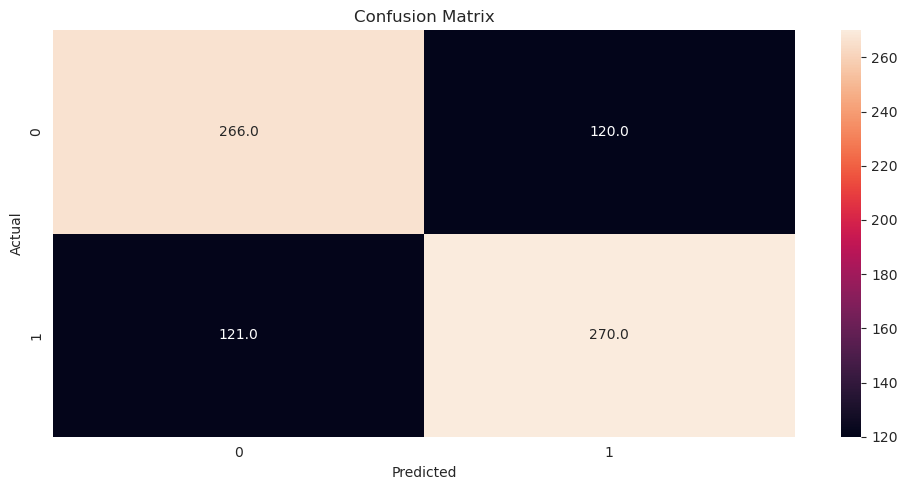

In [50]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(best_rf.predict(X_test),y_test), annot = True,fmt='.1f')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()

##### Step 9: Store Prediction into OneLake back

In [51]:
X_full = data[X_train.columns]
best_predictions = best_rf.predict(X_full)

best_predictions_df = pd.DataFrame(best_predictions, columns=['PredictedWaterQuality'])

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 101, Finished, Available)

In [52]:
result_df = pd.concat([data, best_predictions_df], axis=1)
result_df.head()

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 102, Finished, Available)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,OrganicCarbon,Trihalomethanes,Turbidity,WaterQuality,PredictedWaterQuality
0,9.07,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,0,0
1,3.72,129.42,18630.06,6.64,298.08,592.89,15.18,56.33,4.50,0,0
2,8.10,224.24,19909.54,9.28,367.22,418.61,16.87,66.42,3.06,0,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0,0


In [53]:
result_df.to_csv('/lakehouse/default/Files/Water-Data/water_probability_prediction.csv', index = False)

StatementMeta(, 70df3bb2-27dd-4892-99a1-d6c364325178, 103, Finished, Available)